# Load structure and create supercell

In [113]:
from dynmat import load_unit_cell_from_toml, fractional_to_cartesian_transform
from itertools import combinations

dimensions = (10, 5, 5)
u = load_unit_cell_from_toml("NaCl.toml").supercell(dimensions)


pairs = np.array(list(combinations(u.atom_positions, r=2)))




In [89]:
np.where(np.all(u.atom_positions == [0.8, 0.8, 0. ], axis=1))

(array([440]),)

In [87]:
u.atom_positions[375]

array([0.75, 0.5 , 0.5 ])

In [112]:
dd = periodic_distance(pairs[:,0],pairs[:,1], T)
np.sort(dd)

array([1.        , 1.        , 1.        , ..., 8.38152731, 8.38152731,
       8.38152731])

# create transformation matrix fractional to cartesian

In [88]:
pairs[:,109131]

array([[0.8, 0.8, 0. ],
       [0.8, 0.8, 0. ]])

In [55]:
len(u.atomic_basis)

500

In [52]:
len(dd)

124750

In [34]:
lat, ang = (10, 10, 10), (u.alpha, u.beta, u.gamma)
T = fractional_to_cartesian_transform(lat, ang)

T

array([[1.000000e+01, 6.123234e-16, 6.123234e-16],
       [0.000000e+00, 1.000000e+01, 6.123234e-16],
       [0.000000e+00, 0.000000e+00, 1.000000e+01]])

In [17]:
np.sqrt(0.5)

0.7071067811865476

In [15]:
0.5**(1/2)

0.7071067811865476

In [14]:
periodic_distance(
    [0.5, 0.5, 0.0],
    [0.0, 0.0, 0.0],
    T
)

array([7.07106781])

(array([['a', 'a', 'a', 'b', 'b', 'c'],
        ['b', 'c', 'd', 'c', 'd', 'd']], dtype='<U1'),
 array(['a', 'a', 'a', 'b', 'b', 'c'], dtype='<U1'),
 array(['b', 'c', 'd', 'c', 'd', 'd'], dtype='<U1'))

In [33]:
import numpy as np


def periodic_distance(p1, p2, T=np.eye(3)):
    """
    Computes the periodic distance between two points in a unit cube,
    using a transformation matrix to convert fractional to Cartesian coordinates.

    Parameters:
        p1 (array-like): Fractional coordinates of the first point (e.g., [x1, y1, z1]).
        p2 (array-like): Fractional coordinates of the second point (e.g., [x2, y2, z2]).
        T (array-like): 3x3 transformation matrix to convert fractional to Cartesian coordinates.

    Returns:
        float: The Cartesian periodic distance between the points.
    """
    p1 = np.array(p1) % 1
    p2 = np.array(p2) % 1

    p1 = p1.reshape(-1, 3)
    p2 = p2.reshape(-1, 3)

    # Compute delta in fractional space
    delta = np.abs(p2 - p1)
    delta = np.minimum(delta, 1 - delta)  # Wrap around the boundary

    # Transform fractional deltas to Cartesian
    delta_cartesian = np.dot(delta, T.T)

    # Compute Cartesian distance
    distance = np.sqrt(np.sum(delta_cartesian**2, axis=1))

    return distance

In [4]:
def calculate_force_constant(mass1: float, 
                           mass2: float, 
                           reference_frequency: float = 1.0) -> float:
    """
    Calculate the force constant based on reduced mass and a reference frequency.
    
    Parameters:
        mass1: Mass of first atom in atomic mass units (u)
        mass2: Mass of second atom in atomic mass units (u)
        reference_frequency: Reference vibrational frequency in arbitrary units (default: 1.0)
        
    Returns:
        float: Force constant k = μω², where μ is reduced mass and ω is angular frequency
    """
    # Calculate reduced mass
    reduced_mass = (mass1 * mass2) / (mass1 + mass2)
    
    # Convert reference frequency to angular frequency (ω = 2πν)
    angular_frequency = 2 * np.pi * reference_frequency
    
    # Calculate force constant k = μω²
    force_constant = reduced_mass * angular_frequency**2
    
    return force_constant

def get_atomic_mass(atom_label: str) -> float:
    """
    Get the atomic mass of an element in atomic mass units (u).
    
    Parameters:
        atom_label: Chemical symbol of the element (e.g., 'H', 'C', 'O')
        
    Returns:
        float: Atomic mass in u
    """
    return element(atom_label).mass

def get_harmonic_force(reference_pos: NDArray,
                      reference_labels: NDArray,
                      atom1_pos: NDArray,
                      atom2_pos: NDArray,
                      displacement: NDArray,
                      atom1_label: str,
                      atom2_label: str,
                      distance_matrix: NDArray,
                      reference_frequency: float = 1.0) -> Tuple[NDArray, float]:
    """
    Calculate the harmonic force between two atoms after displacement using mass-dependent force constant.
    
    Parameters:
        reference_pos: Reference positions of all atoms (N, 3)
        reference_labels: Atomic labels for all positions (N,)
        atom1_pos: Position of first atom (3,)
        atom2_pos: Position of second atom (3,)
        displacement: Displacement vector to apply to atom2 (3,)
        atom1_label: Chemical symbol of first atom
        atom2_label: Chemical symbol of second atom
        distance_matrix: Matrix of equilibrium distances between atoms
        reference_frequency: Reference frequency for force constant calculation (default: 1.0)
        
    Returns:
        Tuple containing:
        - NDArray: Force vector (3,) acting on atom2 due to displacement
        - float: Force constant used in calculation
    """
    # Convert inputs to numpy arrays and ensure correct shapes
    atom1_pos = np.asarray(atom1_pos, dtype=np.float64).reshape(3)
    atom2_pos = np.asarray(atom2_pos, dtype=np.float64).reshape(3)
    displacement = np.asarray(displacement, dtype=np.float64).reshape(3)
    
    # Find atom indices in the reference positions
    atom1_mask = np.all(np.isclose(reference_pos, atom1_pos), axis=1)
    atom2_mask = np.all(np.isclose(reference_pos, atom2_pos), axis=1)
    
    atom1_idx = np.where(atom1_mask)[0]
    atom2_idx = np.where(atom2_mask)[0]
    
    if len(atom1_idx) != 1 or len(atom2_idx) != 1:
        raise ValueError(f"Could not uniquely identify atoms. Found {len(atom1_idx)} matches for atom1 and {len(atom2_idx)} for atom2")
    
    # Get equilibrium distance from the distance matrix
    equilibrium_distance = distance_matrix[atom1_idx[0], atom2_idx[0]]
    
    # Calculate new distance after displacement
    displaced_pos = atom2_pos + displacement
    direction = calculate_periodic_direction(atom1_pos, displaced_pos)
    current_distance = periodic_distance(atom1_pos, displaced_pos)
    
    # Get atomic masses and calculate force constant
    mass1 = get_atomic_mass(atom1_label)
    mass2 = get_atomic_mass(atom2_label)
    force_constant = calculate_force_constant(mass1, mass2, reference_frequency)
    
    # Calculate force (F = -k(r - r_0) * direction)
    force_magnitude = force_constant * (equilibrium_distance - current_distance)
    force_vector = force_magnitude * direction
    
    return force_vector, force_constant

In [16]:
u.lattice_lengths

AttributeError: 'UnitCell' object has no attribute 'lattice_lengths'

In [73]:
from dynmat import UnitCell, fractional_to_cartesian_transform, periodic_distance_mat, is_nearest_neighbor
    
u = UnitCell(
    lattice_lengths=(1, 1, 1),
    lattice_angles=(90, 90, 90),
    atomic_basis=[
        ("Na", 0.0, 0.0, 0.0),
        ("Cl", 0.5, 0.5, 0.5)
    ]
).make_supercell((5, 5, 0))

# Get transformation matrix and distances
lat, ang = (u.a, u.b, u.c), (u.alpha, u.beta, u.gamma)
T = fractional_to_cartesian_transform(lat, ang)
positions = np.array(u.atomic_basis)[:,1:].astype("float64")
labels = np.array(u.atomic_basis)[:,1:].astype("float64")
distances = periodic_distance_mat(positions)



array([0.        , 0.50124844, 0.05      , ..., 0.05      , 0.50124844,
       0.        ])

In [9]:
len(u.atomic_basis)*3

150

In [5]:
from dynmat import UnitCell, fractional_to_cartesian_transform, periodic_distance_mat, periodic_distance, is_nearest_neighbors
from itertools import combinations
import numpy as np
from numpy.typing import NDArray
from mendeleev import element


def calculate_force_constant(atom1_label: str, atom2_label: str, reference_frequency: float = 1.0) -> float:
    """
    Calculate force constant based on atomic masses and reference frequency.
    """
    mass1 = element(atom1_label).mass
    mass2 = element(atom2_label).mass
    reduced_mass = (mass1 * mass2) / (mass1 + mass2)
    angular_frequency = 2 * np.pi * reference_frequency
    return reduced_mass * angular_frequency**2


def calculate_periodic_direction(point1: NDArray, point2: NDArray) -> NDArray:
    """
    Calculate unit vector considering periodic boundaries.
    """
    delta = point2 - point1
    delta = delta - np.round(delta)
    norm = np.linalg.norm(delta)
    return delta / norm if norm > 0 else np.zeros_like(delta)


def get_force(positions: NDArray, 
             labels: NDArray,
             atom1: NDArray, 
             atom2: NDArray, 
             displacement: NDArray,
             distance_matrix: NDArray,
             reference_frequency: float = 1.0) -> NDArray:
    """
    Calculate force between two atoms with mass-dependent force constant.
    """
    # Find atom indices and labels
    atom1_idx = np.where(np.all(positions == atom1, axis=1))[0][0]
    atom2_idx = np.where(np.all(positions == atom2, axis=1))[0][0]
    atom1_label = labels[atom1_idx][0]
    atom2_label = labels[atom2_idx][0]
    
    # Get equilibrium distance
    equilibrium_dist = distance_matrix[atom1_idx, atom2_idx]
    
    # Calculate mass-dependent force constant
    k = calculate_force_constant(atom1_label, atom2_label, reference_frequency)
    
    # Calculate new distance and direction after displacement
    displaced_pos = atom2 + displacement
    new_dist = periodic_distance(atom1, displaced_pos)
    direction = calculate_periodic_direction(atom1, displaced_pos)
    equi = np.ravel(equilibrium_dist)[0]
    # Calculate force
    # print( equi)
    return (k * (equi - np.array(new_dist)))/(2*equi**1.7) * direction


def get_forces_3x3(positions: NDArray,
                  labels: NDArray,
                  atom1: NDArray,
                  atom2: NDArray,
                  displacements: NDArray,
                  distance_matrix: NDArray,
                  reference_frequency: float = 1.0) -> NDArray:
    """
    Calculate forces for a set of displacements.
    """
    force_xyz = []
    for d in displacements:
        force = get_force(positions, labels, atom1, atom2, d, distance_matrix, reference_frequency)
        force_xyz.append(force)
    return np.array(force_xyz)


# Example usage:
if __name__ == "__main__":
    # Create unit cell
    u = UnitCell(
        lattice_lengths=(1, 1, 1),
        lattice_angles=(90, 90, 90),
        atomic_basis=[
            ("Na", 0.0, 0.0, 0.0),
            ("Cl", 0.5, 0.5, 0.5)
        ]
    ).make_supercell((2, 2, 2))

    # Get lattice parameters and transformation matrix
    lat, ang = (u.a, u.b, u.c), (u.alpha, u.beta, u.gamma)
    T = fractional_to_cartesian_transform(lat, ang)

    # Extract positions and labels
    pos = np.array(u.atomic_basis)[:, 1:].astype("float64")
    labels = np.array(u.atomic_basis)[:, :1]

    # Calculate distance matrix
    dist = periodic_distance_mat(pos)

    # Define displacements
    dxdydz = np.array([
        [0.1, 0.0, 0.0],
        [0.0, 0.1, 0.0],
        [0.0, 0.0, 0.1],
    ])

    fc_matrix = np.zeros(
        (3 * len(labels), 3 * len(labels))
    )

    # Calculate forces for nearest neighbors
    for i, (label1, atom1) in enumerate(zip(labels, pos)):
        for j, (label2, atom2) in enumerate(zip(labels, pos)):
            if i != j and i < j:
                is_nearest = is_nearest_neighbors(i, j, dist, order=0)
                is_next_nearest = is_nearest_neighbors(i, j, dist, order=1)
                if is_next_nearest or is_nearest:
                    forces = get_forces_3x3(
                        positions=pos,
                        labels=labels,
                        atom1=atom1,
                        atom2=atom2,
                        displacements=dxdydz,
                        distance_matrix=dist,
                        reference_frequency=1.0  # Adjust this value as needed
                    )
                    fc_matrix[i*3:i*3+3, j*3:j*3+3] = forces
                    # print(f"\nForces between {label1[0]}{i} and {label2[0]}{j}:")
                    # print(forces)

0.4330127018922193
0.4330127018922193
0.4330127018922193

Forces between Na0 and Cl1:
[[-51.81235571 -37.00882551 -37.00882551]
 [-37.00882551 -51.81235571 -37.00882551]
 [-37.00882551 -37.00882551 -51.81235571]]
0.5
0.5
0.5

Forces between Na0 and Na2:
[[ -1.43159267  -0.          -7.15796334]
 [ -0.          -1.43159267  -7.15796334]
 [  0.           0.         -73.72000412]]
0.4330127018922193
0.4330127018922193
0.4330127018922193

Forces between Na0 and Cl3:
[[-51.81235571 -37.00882551  37.00882551]
 [-37.00882551 -51.81235571  37.00882551]
 [ 36.39701352  36.39701352 -21.83820811]]
0.5
0.5
0.5

Forces between Na0 and Na4:
[[ -1.43159267  -7.15796334  -0.        ]
 [  0.         -73.72000412   0.        ]
 [ -0.          -7.15796334  -1.43159267]]
0.4330127018922193
0.4330127018922193
0.4330127018922193

Forces between Na0 and Cl5:
[[-51.81235571  37.00882551 -37.00882551]
 [ 36.39701352 -21.83820811  36.39701352]
 [-37.00882551  37.00882551 -51.81235571]]
0.4330127018922193
0.4330

In [7]:
def plot_force_constant_matrix(fc_matrix, atomic_labels):
    """
    Plot force constant matrix with 3x3 block grid lines and atom labels.
    
    Parameters:
        fc_matrix: The force constant matrix (3N x 3N)
        atomic_labels: List of atomic symbols for each atom
    """
    n_atoms = len(atomic_labels)
    n = 3 * n_atoms
    
    # Create figure with appropriate size
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot the matrix
    vmax = 0.8*np.max(np.abs(fc_matrix))
    im = ax.imshow(fc_matrix, cmap='PuOr', aspect='equal', vmin=-vmax, vmax=vmax)
    plt.colorbar(im)
    
    # Add grid lines to separate 3x3 blocks
    for i in range(n_atoms):
        ax.axhline(y=i*3 - 0.5, color='black', linewidth=2)
        ax.axvline(x=i*3 - 0.5, color='black', linewidth=2)
    
    # Create labels for each coordinate of each atom
    coord_labels = []
    for atom in atomic_labels:
        coord_labels.extend([f"{atom}-x", f"{atom}-y", f"{atom}-z"])
    
    # Set ticks at the center of each coordinate
    ticks = np.arange(n)
    
    # Add labels
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(coord_labels, rotation=45, ha='right')
    ax.set_yticklabels(coord_labels)
    
    # Add title
    plt.title('Force Constant Matrix')
    
    # Adjust layout to prevent label clipping
    plt.tight_layout()
    
    return fig, ax

In [1]:
from dynmat import UnitCell, fractional_to_cartesian_transform, periodic_distance_mat, is_nearest_neighbors, get_forces_3x3
from tqdm import tqdm
import numpy as np
u = UnitCell(
        lattice_lengths=(5, 5, 5),
        lattice_angles=(90, 90, 90),
        basis=[
            ("Na", (0.0, 0.0, 0.0)),
            ("Cl", (0.5, 0.5, 0.0))
        ]
).supercell((2, 2, 1))

# Get lattice parameters and transformation matrix
lat, ang = (u.a, u.b, u.c), (u.alpha, u.beta, u.gamma)
T = fractional_to_cartesian_transform(lat, ang)

# Extract positions and labels
pos = u.positions
labels = u.labels

# Calculate distance matrix
dist = periodic_distance_mat(pos)

# Define displacements
dxdydz = np.array([
    [0.1, 0.0, 0.0],
    [0.0, 0.1, 0.0],
    [0.0, 0.0, 0.0],
])*1e-6

fc_matrix = np.zeros(
    (3 * len(labels), 3 * len(labels))
)

# Calculate forces for nearest neighbors
for i, (label1, atom1) in enumerate(zip(tqdm(labels), pos)):
    for j, (label2, atom2) in enumerate(zip(labels, pos)):
        if i != j:
            is_nearest = is_nearest_neighbors(i, j, dist, order=0)
            is_next_nearest = is_nearest_neighbors(i, j, dist, order=1)
            if is_nearest or is_next_nearest:
                forces = get_forces_3x3(
                    positions=pos,
                    labels=labels,
                    atom1=atom1,
                    atom2=atom2,
                    displacements=dxdydz,
                    distance_matrix=dist,
                    reference_frequency=1.0  # Adjust this value as needed
                )
                fc_matrix[i*3:i*3+3, i*3:i*3+3] -= forces
                fc_matrix[i*3:i*3+3, j*3:j*3+3] = forces

100%|██████████| 8/8 [00:31<00:00,  3.89s/it]


In [5]:
u = UnitCell(
        lattice_lengths=(5, 5, 5),
        lattice_angles=(90, 90, 90),
        basis=[
            ("Na", (0.0, 0.0, 0.0)),
            ("Cl", (0.5, 0.5, 0.5))
        ]
).supercell((2, 2, 1))
u.positions

array([[0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.5 ],
       [0.  , 0.5 , 0.  ],
       [0.25, 0.75, 0.5 ],
       [0.5 , 0.  , 0.  ],
       [0.75, 0.25, 0.5 ],
       [0.5 , 0.5 , 0.  ],
       [0.75, 0.75, 0.5 ]])

(<Figure size 1200x1000 with 2 Axes>,
 <Axes: title={'center': 'Force Constant Matrix'}>)

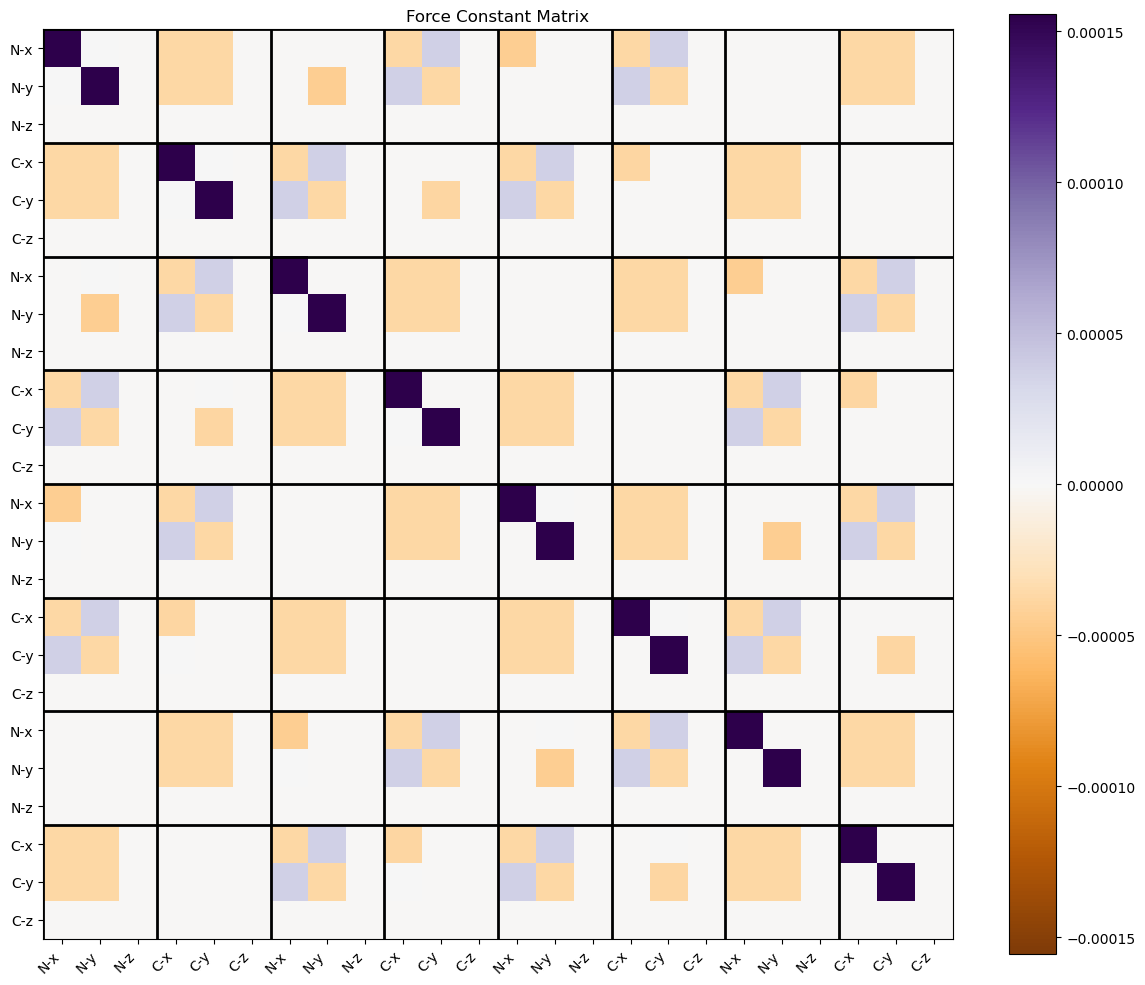

In [9]:
import matplotlib.pyplot as plt

plot_force_constant_matrix(fc_matrix,u.labels)

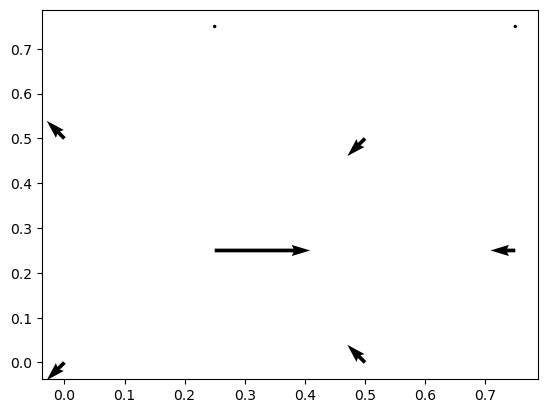

In [38]:
i = 3
fx = fc_matrix[i, ::3]
fy = fc_matrix[i, 1::3]
x = [at[1] for at in u.atomic_basis]
y = [at[2] for at in u.atomic_basis]

plt.quiver(x,y,fx,fy)
# plt.colorbar()

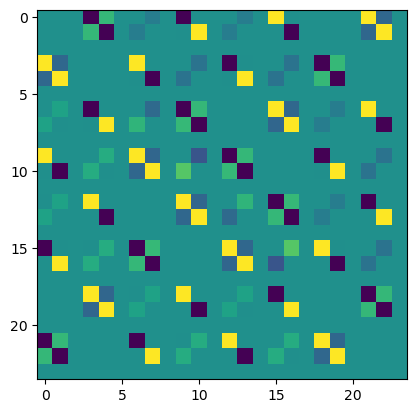

In [39]:
plt.imshow(fc_matrix - fc_matrix.T)

In [43]:
len(values)/3

8.0

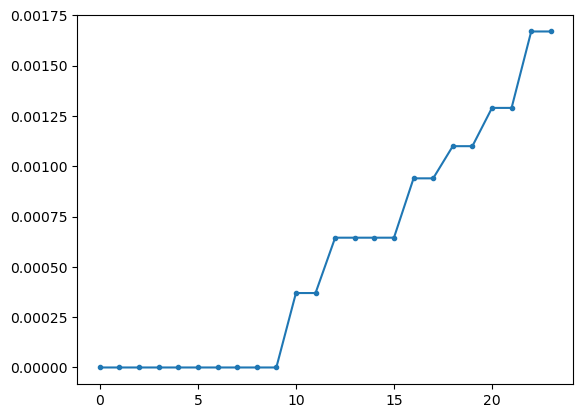

In [77]:
import numpy as np

values, eigen = np.linalg.eigh(fc_matrix+fc_matrix.T)


plt.plot(np.sort(values),'.-')

In [98]:
values, eigen = np.linalg.eigh(fc_matrix+fc_matrix.T)

#check it all works:
# ((eigen@np.diag(values)@eigen.T) - (fc_matrix+fc_matrix.T))[0]

ivalues = [0 if (l<1e-10) else 1/l for l in values]

covariancesss = (eigen@np.diag(ivalues)@eigen.T)

In [ ]:
import c

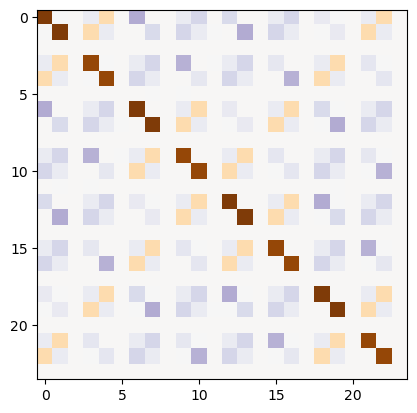

In [101]:
clim = np.amax(covariancesss)

plt.imshow(covariancesss, clim=(-clim,clim), cmap="PuOr_r")

In [1]:
covariancesss

NameError: name 'covariancesss' is not defined

In [5]:
u.atomic_basis

[('Na', 0.0, 0.0, 0.0),
 ('Cl', 0.25, 0.25, 0.5),
 ('Na', 0.0, 0.5, 0.0),
 ('Cl', 0.25, 0.75, 0.5),
 ('Na', 0.5, 0.0, 0.0),
 ('Cl', 0.75, 0.25, 0.5),
 ('Na', 0.5, 0.5, 0.0),
 ('Cl', 0.75, 0.75, 0.5)]

In [ ]:
is_nearest_neighbor([0.0, 0.0, 0.0],[0.25, 0.25, 0.5]

In [3]:
from dynmat import UnitCell, fractional_to_cartesian_transform, periodic_distance_mat, periodic_distance, is_nearest_neighbor
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray

u = UnitCell(
    lattice_lengths = (1, 1, 1),
    lattice_angles = (90, 90, 90),
    atomic_basis = [
        ("Na", 0.0, 0.0, 0.0),("Cl", 0.5, 0.5, 0.5)
    ]
).make_supercell((5, 5, 0))

lat, ang = (u.a, u.b, u.c),(u.alpha, u.beta, u.gamma)
T = fractional_to_cartesian_transform(lat, ang)

pos = np.array(u.atomic_basis)[:,1:].astype("float64")
label = np.array(u.atomic_basis)[:,:1].astype("str")

dist = periodic_distance_mat(pos)

def get_force(pos, atom1, atom2, d):
    atom1 = np.array(atom1)
    atom2 = np.array(atom2)
    atom1_id = np.where(np.all(pos == atom1, axis=1))[0]
    atom2_id = np.where(np.all(pos == atom2, axis=1))[0]
    equilibrium_dist = dist[atom1_id, atom2_id]
    new_dist = periodic_distance(atom1, atom2 + d)
    return (np.ravel(equilibrium_dist)[0] - np.array(new_dist)) * periodic_direction_vector(atom1, atom2 + d)


def get_forces_3x3(positions, label1, atom1, label2, atom2, dxdydz):
    force_xyz = []
    for d in dxdydz:
        force_x, force_y, force_z = get_force(positions, label1, atom1, label2, atom2, d)
        force_xyz.append([force_x, force_y, force_z])
    force_xyz = np.array(force_xyz)

    return force_xyz

dxdydz = [
    [0.1, 0.0, 0.0],
    [0.0, 0.1, 0.0],
    [0.0, 0.0, 0.0],
]

for label1, atom1 in zip(label, pos):
    for label2, atom2 in zip(label, pos):
        if not np.all(atom1 == atom2):
            atom1_id = np.where(np.all(pos == atom1, axis=1))[0]
            atom2_id = np.where(np.all(pos == atom2, axis=1))[0]
            if is_nearest_neighbor(atom1_id,atom2_id, dist):
                print("b")
                x = get_forces_3x3(pos, label1, atom1, label2, atom2, dxdydz)
                print(x)
print("a")

a


In [2]:
def periodic_direction_vector(p1, p2):
    """
    Computes the normalized direction vector between two points in a periodic unit cube [0,1].
    Returns the shortest unit vector from p1 to p2 considering periodic boundaries.
    
    Parameters:
        p1 (array-like): Coordinates of the first point [x, y, z]
        p2 (array-like): Coordinates of the second point [x, y, z]
        
    Returns:
        ndarray: The normalized direction vector from p1 to p2 considering periodic boundaries
    """
    # Convert inputs to numpy arrays and ensure they're in [0,1]
    p1 = np.array(p1, dtype=float) % 1
    p2 = np.array(p2, dtype=float) % 1
    
    # Calculate direct difference
    direct_diff = p2 - p1
    
    # For each component, check if going around the other way is shorter
    periodic_diff = np.where(direct_diff > 0.5, direct_diff - 1, 
                         np.where(direct_diff < -0.5, direct_diff + 1, direct_diff))
    
    # Normalize the vector
    norm = np.sqrt(np.sum(periodic_diff * periodic_diff))
    if norm > 0:
        periodic_diff = periodic_diff / norm
    
    return periodic_diff

In [34]:
np.linalg.norm([0.1, 0.1, 0.1])

0.17320508075688776

In [44]:
v = periodic_direction_vector(
    [0.1, 0.1, 0.1],
    [0.9, 0.9, 0.9]
)

v

array([-0.57735027, -0.57735027, -0.57735027])

In [20]:
from numpy import abs, array, minimum, sqrt, sum, zeros, meshgrid, arange

def periodic_distance(positions_with_ids):
    """
    Computes the periodic distance between all pairs of points in a unit cube.
    
    Parameters:
        positions_with_ids: List of [id, x, y, z] arrays or array of shape (N, 4)
        where the first column contains IDs and the remaining columns are coordinates
    
    Returns:
        distances: Array of shape (N_points, N_points) containing pairwise distances
        where distances[i,j] gives distance between atom with ID positions_with_ids[i,0]
        and atom with ID positions_with_ids[j,0]
    """
    # Convert input to numpy array if not already
    pos_array = array(positions_with_ids)
    
    # Extract IDs and coordinates
    ids = pos_array[:,0]
    coords = pos_array[:,1:]
    
    # Apply periodic boundary conditions to coordinates
    coords = coords % 1
    
    # Reshape coordinates for broadcasting
    coords1 = coords.reshape(-1, 1, 3)  # Shape: (N, 1, 3)
    coords2 = coords.reshape(1, -1, 3)  # Shape: (1, N, 3)
    
    # Calculate periodic distances
    delta = abs(coords2 - coords1)  # Shape: (N, N, 3)
    delta = minimum(delta, 1 - delta)  # Wrap around boundary
    distances = sqrt(sum(delta**2, axis=2))  # Shape: (N, N)
    
    return ids, distances



# Example positions: each row is [id, x, y, z]
positions = array([
    [0, 0.1, 0.1, 0.1],
    [1, 0.2, 0.2, 0.2],
    [2, 0.9, 0.9, 0.9]
])

ids, distances = periodic_distance(np.array(u.atomic_basis)[:,:])

# To get distance between atoms with specific IDs:
id1, id2 = 0, 1
idx1 = list(ids).index(id1)
idx2 = list(ids).index(id2)
dist = distances[idx1, idx2]
print(f"Distance between atoms {id1} and {id2}: {dist}")

Distance between atoms 0 and 1: 0.01414213562373095


In [47]:
u.

25000000

In [50]:
distances.shape[0]**2

25000000

In [45]:
(50*50)**2

6250000

In [43]:
np.where([distances[1221,:] < 0.01414214])

(array([0, 0, 0, 0, 0]), array([1220, 1221, 1222, 1320, 1322]))

In [5]:

i = 0
for atom1, x1, y1, z1 in u.atomic_basis:
    for atom2, x2, y2, z2 in u.atomic_basis:
        p = periodic_distance(
            [x1, y1, z1],
            [x2, y2, z2],
        )
        break

In [6]:
u.atomic_basis

[('Na', 0.0, 0.0, 0.0),
 ('Cl', 0.05, 0.05, 0.0),
 ('Na', 0.0, 0.1, 0.0),
 ('Cl', 0.05, 0.15, 0.0),
 ('Na', 0.0, 0.2, 0.0),
 ('Cl', 0.05, 0.25, 0.0),
 ('Na', 0.0, 0.3, 0.0),
 ('Cl', 0.05, 0.35, 0.0),
 ('Na', 0.0, 0.4, 0.0),
 ('Cl', 0.05, 0.45, 0.0),
 ('Na', 0.0, 0.5, 0.0),
 ('Cl', 0.05, 0.55, 0.0),
 ('Na', 0.0, 0.6, 0.0),
 ('Cl', 0.05, 0.65, 0.0),
 ('Na', 0.0, 0.7, 0.0),
 ('Cl', 0.05, 0.75, 0.0),
 ('Na', 0.0, 0.8, 0.0),
 ('Cl', 0.05, 0.85, 0.0),
 ('Na', 0.0, 0.9, 0.0),
 ('Cl', 0.05, 0.95, 0.0),
 ('Na', 0.1, 0.0, 0.0),
 ('Cl', 0.15, 0.05, 0.0),
 ('Na', 0.1, 0.1, 0.0),
 ('Cl', 0.15, 0.15, 0.0),
 ('Na', 0.1, 0.2, 0.0),
 ('Cl', 0.15, 0.25, 0.0),
 ('Na', 0.1, 0.3, 0.0),
 ('Cl', 0.15, 0.35, 0.0),
 ('Na', 0.1, 0.4, 0.0),
 ('Cl', 0.15, 0.45, 0.0),
 ('Na', 0.1, 0.5, 0.0),
 ('Cl', 0.15, 0.55, 0.0),
 ('Na', 0.1, 0.6, 0.0),
 ('Cl', 0.15, 0.65, 0.0),
 ('Na', 0.1, 0.7, 0.0),
 ('Cl', 0.15, 0.75, 0.0),
 ('Na', 0.1, 0.8, 0.0),
 ('Cl', 0.15, 0.85, 0.0),
 ('Na', 0.1, 0.9, 0.0),
 ('Cl', 0.15, 0.95, 0.0),


In [7]:
alpha = np.deg2rad(90)
beta = np.deg2rad(90)
gamma = np.deg2rad(120)
T = fractional_to_cartesian_transform(
    (5, 5, 5),
    (alpha, beta, gamma)
)


T @ (1, 0, 0), T @ (0, 1, 0), T @ (0, 0, 1)

(array([5., 0., 0.]),
 array([-2.5       ,  4.33012702,  0.        ]),
 array([3.06161700e-16, 5.30287619e-16, 5.00000000e+00]))

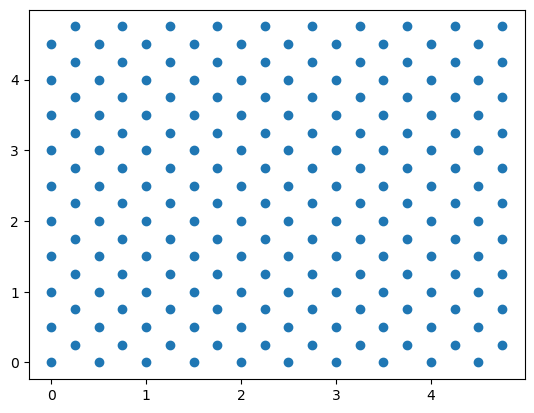

In [8]:
alpha = np.deg2rad(90)
beta = np.deg2rad(60)
gamma = np.deg2rad(90)
T = fractional_to_cartesian_transform(
    (5, 5, 5),
    (alpha, beta, alpha)
).T

atom_x, atom_y, _ = np.array([T @ (x, y, 0)   for _, x, y, _ in u.atomic_basis]).T
plt.scatter(atom_x, atom_y)

Text(0.5, 0.92, 'Unit Cell with Angles 40°, 40°, 40°')

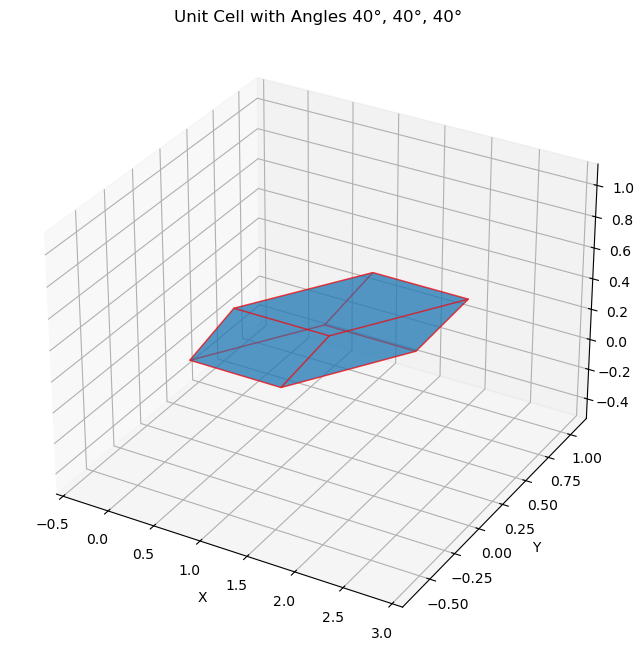

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Define parameters for the unit cell at angles 40°, 40°, 40°
a, b, c = 1.0, 1.0, 1.0
lat_a, lat_b, lat_c = 1.0, 1.0, 1.0
alpha, beta, gamma = np.deg2rad(40), np.deg2rad(40), np.deg2rad(40)

# Compute the transformation matrix
def compute_transformation_matrix(a, b, c, alpha, beta, gamma):
    cot_alpha = 1 / np.tan(alpha)
    cot_beta = 1 / np.tan(beta)
    cot_gamma = 1 / np.tan(gamma)

    T = np.array([
        [a, b * np.cos(gamma), c * np.cos(beta)],
        [0, b * np.sin(gamma), c * (cot_alpha - cot_beta * cot_gamma)],
        [0, 0, c * np.sqrt(
            1 - np.cos(beta)**2 - (
                (cot_alpha - cot_beta * cot_gamma)
            )**2
        )]
    ])
    return T

T = compute_transformation_matrix(a, b, c, alpha, beta, gamma)

# Define the corners of the unit cell in fractional coordinates
fractional_coords = np.array([
    [0, 0, 0], [1, 0, 0], [0, 1, 0], [0, 0, 1],
    [1, 1, 0], [1, 0, 1], [0, 1, 1], [1, 1, 1]
])

# Transform to real coordinates
real_coords = fractional_coords @ T.T

# Define the faces of the unit cell
faces = [
    [0, 1, 4, 2], [0, 2, 6, 3], [0, 1, 5, 3],
    [7, 6, 2, 4], [7, 5, 1, 4], [7, 6, 3, 5]
]

# Visualize the unit cell
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw the faces
for face in faces:
    poly = Poly3DCollection([real_coords[face]], alpha=0.5, edgecolor='r')
    ax.add_collection3d(poly)

# Set labels and limits
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([real_coords[:, 0].min() - 0.5, real_coords[:, 0].max() + 0.5])
ax.set_ylim([real_coords[:, 1].min() - 0.5, real_coords[:, 1].max() + 0.5])
ax.set_zlim([real_coords[:, 2].min() - 0.5, real_coords[:, 2].max() + 0.5])
ax.set_title("Unit Cell with Angles 40°, 40°, 40°")


In [10]:
cot = lambda x: 1/np.tan(x)
csc = lambda x: 1/np.sin(x)
transformation = np.array([
    [lat_a, lat_b * np.cos(gamma), lat_c * np.cos(beta)],
    [0, lat_b * np.sin(gamma), lat_c * np.sin(beta) * csc(alpha)],
    [0, 0, lat_c * np.sin(beta) * cot(alpha)]
])


transformation

array([[1.        , 0.76604444, 0.76604444],
       [0.        , 0.64278761, 1.        ],
       [0.        , 0.        , 0.76604444]])

In [11]:
T

array([[ 1.        ,  0.76604444,  0.76604444],
       [ 0.        ,  0.64278761, -0.22852303],
       [ 0.        ,  0.        ,  0.60079375]])